In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('../')
import pytorch_optim as optim_local
import os
import argparse
from models import *
from logger import Logger, savefig
import numpy as np
import pandas as pd 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb

/Users/karimimohammedbelhal/Desktop/ML_Research/BaiduResearch/Research/baiduresearch/Code/c)ConvDiag/SGDM/cifar10


In [2]:
#data prep
transform_train = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transform_test)

In [3]:
#parameters
batch_size = 128
dataset = "MNIST"
lr = 0.1
momentum = 0.9
gamma = 0.1
weight_decay = 5e-4
beta2 = 0.999
burnin = 10
window = 10 #stationary test window (epochs)
sim = 'ip' #['ip', 'cosine'] inner prod. similarity
schedule = [1, 3] # 'Either str diagnostic / plateau or epochs to decrease learning rate at.')
momentum_switch = False #Momentum reduction boolean
early_threshold = 0.2 #threshold for norm-based momentum switch
num_reduce = 1 #if diagnostic, number of times to reduce LR
debug = False

In [4]:
#train and test loads
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [5]:
#net = MnistNet()
model = "MnistNetSmall"
net = MnistNetSmall()
device ='cuda:{}'.format(args.gpu[0]) if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
net = net.to(device)

In [6]:
#Create checkpoints log file
logname = model
title = '{}-{}'.format(dataset, logname)
checkpoint_dir = 'checkpoint/checkpoint_{}'.format(dataset)
logger = Logger('{}/log{}.txt'.format(checkpoint_dir, logname), title=title)
logger.set_names(['Learning Rate', 'Momentum', 'Train Loss', 'Test Loss', 'Train Acc.', 'Test Acc.',
                      'IP Sum', 'IP Mean', 'IP Std', 'Grad Norm'])
logger_diag = Logger('{}/log{}_diagnostic.txt'.format(checkpoint_dir, logname), title=title)
logger_diag.set_names(['Learning Rate', 'Momentum','newstat', 'Train Loss','Train Acc.', 'iploss'])

In [7]:
#OPTIMIZATION params
optimizer = "ADAM"
criterion = nn.CrossEntropyLoss()
if optimizer =='signSGD':
    optimizer = optim_local.sign_SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, sim=sim)
elif optimizer == 'SGDM':
    optimizer = optim_local.SGD_Diagnostic_Nonconvex(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, sim=sim)
elif optimizer == 'ADAM':
    optimizer = optim_local.Adam_Diagnostic(net.parameters(), lr=1e-3, betas=(momentum, beta2), eps=1e-8, weight_decay=0, amsgrad=False)

In [8]:
if 'plateau' in schedule:
    scheduler = optim_local.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=burnin)

In [9]:
net.parameters()

<generator object parameters at 0x11fa78af0>

In [10]:
grad_norm = []
train_loss_ls = []
test_stat = 0.0
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0; global train_loss_ls
    correct = 0
    total = 0
    ip_loss = []; global test_stat
    grad_loss = []; global grad_norm
    ind = 0
    newstat = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ind += 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        _, diag_args = optimizer.step()
        ip_loss.append(diag_args['ip_loss'])
        grad_loss.append(diag_args['grad_loss'])

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        
        newstat = ind**(0.2)
        logger_diag.append([lr, momentum,newstat, train_loss, 100.*correct/total, np.sum(ip_loss)])
        
        if not debug:
            if ind%100 == 0:
                print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d) | IP_sum: %.3f'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total, np.sum(ip_loss)))
#            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d) | IP_sum: %.3f'
#                        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total, np.sum(ip_loss)))

    # convergence tests based on inner product of loss list from epoch
    diag_stats = {'ip_loss_sum':np.sum(ip_loss), 'ip_loss_mean':np.mean(ip_loss), 'ip_loss_std':np.std(ip_loss),
                  'grad_norm_mean':np.mean(grad_loss)}
    grad_norm.append(diag_stats['grad_norm_mean'])
    train_loss_ls.append(train_loss)

    if (momentum_switch and momentum_ind == -1) or (not momentum_switch and epoch > burnin):
        test_stat += np.sum(ip_loss)

    return (train_loss, 100.*correct/total, diag_stats)

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        ind = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ind +=1
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if not debug:
                if ind%100 == 0:
                    print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d) | test stat: %.3f'
                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total, test_stat))
#                progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d) | test stat: %.3f'
#                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total, test_stat))

    return (test_loss, 100.*correct/total)

def save_checkpoint(state, test_acc):
    # Save checkpoint.
    global best_acc
    if test_acc > best_acc:
        print('Saving..')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './{}/ckpt.{}'.format(checkpoint_dir, logname))
        best_acc = test_acc

def adjust_learning_rate(optimizer, epoch, diag_stats):#, grad_norm, ip_loss):
    global lr
    global momentum
    global num_reduce
    global momentum_ind

    def change_momentum(m_new, opt):
        '''toggles momentum indicator and changes momentum parameter'''
        global momentum
        global momentum_ind

        opt.change_momentum(m_new)
        momentum_ind *= -1
        momentum = m_new
        print('Momentum change from %.2f to %.2f after epoch %d' % (momentum, final_momentum, epoch))

    # Momentun Reduction
    if momentum_switch and epoch > 0 and momentum_ind == 1 and \
        np.abs(train_loss_ls[epoch]-train_loss_ls[epoch-1])/train_loss_ls[epoch-1] < early_threshold:
        #np.abs(grad_norm[epoch]-grad_norm[epoch-1])/grad_norm[epoch-1] < early_threshold:
        change_momentum(final_momentum, optimizer)

    if 'plateau' in schedule and num_reduce >= 1 and momentum_ind == -1:
        if scheduler.step(diag_stats['ip_loss_sum']):
            lr *= gamma
            num_reduce -= 1
            change_momentum(momentum, optimizer)
        # if diag_stats['adf_convg'] and epoch > burnin:
        #     lr *= gamma
        #     burnin = epoch + burnin
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr
    elif 'diagnostic' in schedule and num_reduce >= 1 and momentum_ind == -1 and epoch > burnin:
        if np.sum(test_stat) < 0.0:
            print('LR reduce from %.2f to %.2f at epoch %d' % (lr, lr*gamma, epoch))
            lr *= gamma
            num_reduce -= 1
            change_momentum(momentum, optimizer)
    elif (epoch+1) in schedule and momentum_switch:
        lr *= gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        change_momentum(momentum, optimizer)
        momentum_ind = 1 #only matters for momentum_switch=True case

In [ ]:
epochs = 2
for epoch in range(start_epoch, start_epoch+epochs):
    train_loss, train_acc, diag_stats = train(epoch)
    test_loss, test_acc = test(epoch)

    # append logger file
    logger.append([lr, momentum, train_loss, test_loss, train_acc, test_acc,
                   #diag_stats['ip_loss_sum']
                   test_stat, diag_stats['ip_loss_mean'], diag_stats['ip_loss_std'], diag_stats['grad_norm_mean']])

    adjust_learning_rate(optimizer, epoch, diag_stats)

    save_checkpoint({
        'net': net.state_dict(),
        'acc': test_acc,
        'epoch': epoch,
    }, test_acc)


Epoch: 0
> /Users/karimimohammedbelhal/Desktop/ML_Research/BaiduResearch/Research/baiduresearch/Code/c)ConvDiag/SGDM/cifar10/pytorch_optim/adam_diagnostic.py(89)step()
-> if p.grad is None:
(Pdb) p
*** SyntaxError: SyntaxError('unexpected EOF while parsing', ('<string>', 0, 0, ''))
(Pdb) p.grad
*** SyntaxError: SyntaxError('invalid syntax', ('<string>', 1, 1, '.grad'))
(Pdb) grad
*** NameError: name 'grad' is not defined
(Pdb) print(p.grad)
tensor([[[[-9.3725e-03, -9.0243e-03, -1.1633e-02, -1.2358e-02, -2.3254e-02],
          [-2.4516e-02, -1.8932e-02, -1.4882e-02, -2.0887e-02, -3.0866e-02],
          [-2.1656e-02, -9.5700e-03, -1.0107e-02, -1.1516e-02, -5.7591e-03],
          [-2.1998e-02, -1.0829e-02,  1.3390e-03,  6.4737e-03,  7.8990e-03],
          [-2.2777e-02, -9.9616e-03,  5.3638e-03,  1.2977e-02,  6.8614e-03]]],


        [[[-2.5371e-02, -1.9430e-02, -4.2051e-03,  1.8476e-03,  5.7974e-03],
          [-2.0373e-02, -1.8645e-02,  4.0796e-03,  9.4772e-03,  3.7815e-04],
          [

(Pdb) print(p)
Parameter containing:
tensor([[[[-1.5120e-03,  9.0228e-02,  4.4960e-02, -4.4927e-02,  1.5479e-01],
          [ 1.4023e-01, -1.6497e-01, -1.5538e-01,  1.7724e-01,  5.1844e-02],
          [ 1.8195e-01, -1.7039e-01,  1.1459e-01,  1.8783e-01, -5.0787e-02],
          [-9.8871e-02, -9.7618e-02,  2.3428e-02, -1.3901e-01, -1.9493e-01],
          [-5.6884e-03,  1.0433e-01,  3.6478e-02,  9.3584e-02, -9.0836e-02]]],


        [[[ 1.7567e-01, -6.7193e-02, -4.3259e-02, -2.1216e-02,  1.6895e-01],
          [-6.7055e-02,  1.0875e-01,  1.9788e-01,  7.4923e-02,  2.3137e-02],
          [-1.7442e-01, -1.7435e-01,  7.5386e-02, -7.7979e-02,  1.9094e-01],
          [-8.9927e-02,  1.4015e-01,  2.8547e-02,  8.5981e-02, -3.0735e-02],
          [-5.2838e-02,  1.9434e-01,  1.9686e-01,  1.0385e-02, -4.4910e-02]]],


        [[[ 1.8881e-01,  1.3651e-01,  1.6141e-01, -1.7122e-01, -1.2837e-03],
          [-1.3666e-01,  5.4716e-02,  1.6303e-01, -1.6479e-01,  8.9369e-02],
          [ 7.7903e-02, -9.4949

(Pdb) print(group['params'].shape)
*** AttributeError: 'list' object has no attribute 'shape'
(Pdb) print(len(group['params']))
4


/Users/karimimohammedbelhal/Desktop/ML_Research/masterenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


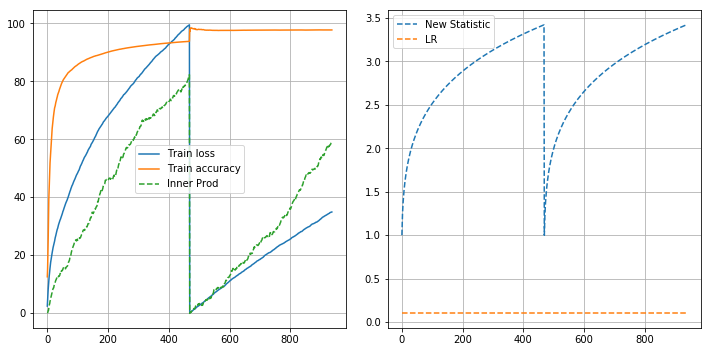

In [37]:
filediag = 'checkpoint/checkpoint_MNIST/logMnistNetSmall_diagnostic.txt'
run = pd.read_table(filediag, index_col = 0, sep = '\t')
xaxis = range(len(run['Train Loss']))
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.plot(xaxis, run['Train Loss'], label='Train loss')
plt.plot(xaxis, run['Train Acc.'], label='Train accuracy')
plt.plot(xaxis, run['iploss'], label='Inner Prod', linestyle='dashed')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xaxis, run['newstat'], label='New Statistic', linestyle='dashed')
plt.plot(xaxis, list(run.index), label='LR', linestyle='dashed')
plt.grid(True)
plt.legend()

/Users/karimimohammedbelhal/Desktop/ML_Research/masterenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


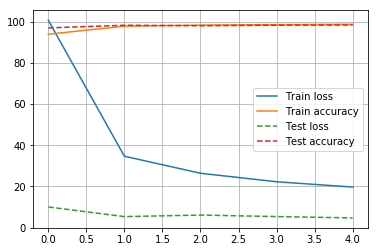

In [14]:
file = 'checkpoint/checkpoint_MNIST/logMnistNetSmall.txt'
run = pd.read_table(file, index_col = 0, sep = '\t')
xaxis = range(len(run['Train Loss']))
plt.plot(xaxis, run['Train Loss'], label='Train loss')
plt.plot(xaxis, run['Train Acc.'], label='Train accuracy')
plt.plot(xaxis, run['Test Loss'], label='Test loss', linestyle='dashed')
plt.plot(xaxis, run['Test Acc.'], label='Test accuracy', linestyle='dashed')
plt.grid(True)
plt.legend()